# Analytical linear fit:
This Python macro illustrates how to perform a linear fit **analytically**, i.e. without any minimisation (e.g. by Minuit), and thus much faster. This can be done, since one can differentiate the Chi2, set this to zero and solve for both intercept and slope.

## References:
- Note on course webpage
- Bevington: Chapter 6

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   8th of November 2020

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

### Program settings:

In [3]:
r = np.random                         # Random generator
r.seed(42)                            # Set a random seed (but a fixed one - more on that later.)
save_plots = False

In [4]:
Nexp = 10       # Number of datasets fitted
Npoints = 9
alpha0 = 3.6
alpha1 = 0.3
sigmay = 1.0

# Generating and fitting data:
In the following, we generate data points following a simple line and fit these both **analytically** and **numerically**. The linear fit (and only this) can be done analytically, as discussed in Barlow chapter 6.2 and outlined here: http://www.nbi.dk/~petersen/Teaching/Stat2019/StraightLineFit.pdf.
The numerical fit of the line (and any other function) is done iteratively by Minuit. The code is slightly shorter, but a lot slower, as the code will typically test many (50+) possible combination of fit parameters!

In [8]:
# Arrays for storing fit results:
array_alpha0 = np.zeros(Nexp)
array_alpha1 = np.zeros(Nexp)
array_Chi2 = np.zeros(Nexp)
array_Prob = np.zeros(Nexp)

# Loop, repeating the data generation and fit:
for iexp in range(Nexp) : 

    # Generating data by filling values into (x,y) and associated uncertainties (here chosen to be 0 for x):
    x = np.arange(Npoints)+1
    ex = np.zeros_like(x)
    y = alpha0 + alpha1*x + r.normal(0, sigmay, Npoints) #+ alpha2*x**2
    ey = sigmay*np.ones_like(x)

    # ------------------------------------------------------------------ #
    # Analytical fit:
    # ------------------------------------------------------------------ #
    # Calculate the relevant sums (see note):
    s = len(x)
    sx = np.sum(x)
    sxx = np.sum(x**2)
    sy = np.sum(y)
    sxy = np.sum(x*y)
    
    # Use sums in calculations:
    Delta = sxx * s - sx**2
    alpha0_calc = (sy  * sxx - sxy * sx) / Delta
    alpha1_calc = (sxy * s   - sy  * sx) / Delta
    sigma_alpha0_calc = sigmay * np.sqrt(sxx / Delta)
    sigma_alpha1_calc = sigmay * np.sqrt(s   / Delta)

    # So now you have data points and a fit/theory. How to get the fit quality?
    # The answer is to calculate the Chi2 and Ndof, and from these two values get their
    # probability using the ChiSquare function (e.g. from scipy):
    Chi2_calc = 0.0
    for i in range( Npoints ) : 
        fit_value = alpha0_calc + alpha1_calc * x[i]
        Chi2_calc += ((y[i] - fit_value) / ey[i])**2
    
    Nvar = 2                     # Number of variables (alpha0 and alpha1)
    Ndof_calc = Npoints - Nvar   # Number of degrees of freedom = Number of data points - Number of variables
    
    # From Chi2 and Ndof, one can calculate the probability of obtaining this
    # or something worse (i.e. higher Chi2). This is a good function to have!
    # We will discuss in class, why/how this function works, and how it plays a central role in statistics.
    from scipy import stats
    Prob_calc =  stats.chi2.sf(Chi2_calc, Ndof_calc) # The chi2 probability given N degrees of freedom (Ndof)
    
    # Fill the arrays with fit results (to produce plots of these at the end):
    array_alpha0[iexp] = alpha0_calc
    array_alpha1[iexp] = alpha1_calc
    array_Chi2[iexp] = Chi2_calc
    array_Prob[iexp] = Prob_calc
    
    
    # ------------------------------------------------------------------ #
    # Numerical fit:
    # ------------------------------------------------------------------ #
    # Define a fit function:
    def fit_function(x, alpha0, alpha1):
        return alpha0 + alpha1*x

    # Now we define a ChiSquare to be minimised (using probfit), where we set various settings and starting parameters:
    chi2_object = Chi2Regression(fit_function, x, y, ey) 
    minuit = Minuit(chi2_object, pedantic=False, alpha0=1, alpha1=1, print_level=0)  
    minuit.migrad();  # perform the actual fit
    minuit_output = [minuit.get_fmin(), minuit.get_param_states()] # save the output parameters in case needed
    
    alpha0_fit = minuit.values['alpha0']
    alpha1_fit = minuit.values['alpha1']
    sigma_alpha0_fit = minuit.errors['alpha0']
    sigma_alpha1_fit = minuit.errors['alpha1']
    
    # In Minuit, you can just ask the fit function for it:
    Chi2_fit = minuit.fval # the chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_calc) # The chi2 probability given N degrees of freedom (Ndof, taken from above!)
    
    # Let us see what the fit gives for the first couple of datasets:
    if (iexp < 10) :
        print(f"  Ana. Fit: a0={alpha0_calc:6.3f}+-{sigma_alpha0_calc:5.3f}  a1={alpha1_calc:5.3f}+-{sigma_alpha1_calc:5.3f}  p={Prob_calc:6.4f}"+
              f"  Num. Fit: a0={alpha0_fit:6.3f}+-{sigma_alpha0_fit:5.3f}  a1={alpha1_fit:5.3f}+-{sigma_alpha1_fit:5.3f}  p={Prob_fit:6.4f}")


  Ana. Fit: a0= 3.596+-0.726  a1=0.273+-0.129  p=0.8048  Num. Fit: a0= 3.596+-0.726  a1=0.273+-0.129  p=0.8048
  Ana. Fit: a0= 2.384+-0.726  a1=0.523+-0.129  p=0.8135  Num. Fit: a0= 2.384+-0.726  a1=0.523+-0.129  p=0.8135
  Ana. Fit: a0= 3.201+-0.726  a1=0.398+-0.129  p=0.2321  Num. Fit: a0= 3.201+-0.726  a1=0.398+-0.129  p=0.2321
  Ana. Fit: a0= 3.303+-0.726  a1=0.435+-0.129  p=0.1219  Num. Fit: a0= 3.303+-0.726  a1=0.435+-0.129  p=0.1219
  Ana. Fit: a0= 2.912+-0.726  a1=0.328+-0.129  p=0.8453  Num. Fit: a0= 2.912+-0.726  a1=0.328+-0.129  p=0.8453
  Ana. Fit: a0= 4.054+-0.726  a1=0.212+-0.129  p=0.2378  Num. Fit: a0= 4.054+-0.726  a1=0.212+-0.129  p=0.2378
  Ana. Fit: a0= 3.553+-0.726  a1=0.292+-0.129  p=0.6738  Num. Fit: a0= 3.553+-0.726  a1=0.292+-0.129  p=0.6738
  Ana. Fit: a0= 3.917+-0.726  a1=0.268+-0.129  p=0.3798  Num. Fit: a0= 3.917+-0.726  a1=0.268+-0.129  p=0.3798
  Ana. Fit: a0= 4.626+-0.726  a1=0.151+-0.129  p=0.4542  Num. Fit: a0= 4.626+-0.726  a1=0.151+-0.129  p=0.4542
 

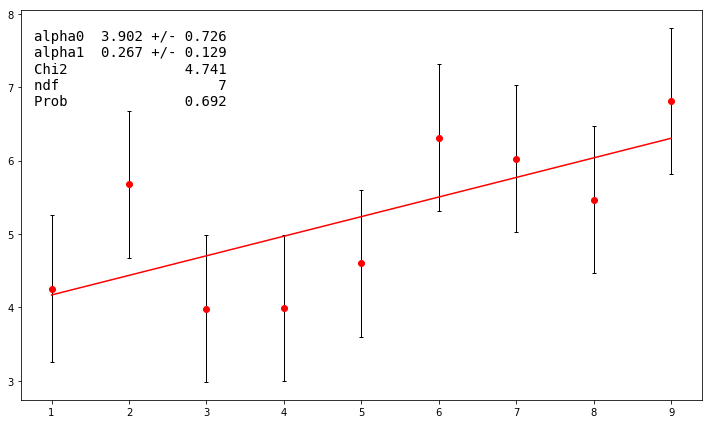

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x, y, ey, fmt='ro', ecolor='k', elinewidth=1, capsize=2, capthick=1)
ax.plot(x, fit_function(x, *minuit.args), '-r')
plt.close()

d = {'alpha0':   [alpha0_calc, sigma_alpha0_calc],
     'alpha1':   [alpha1_calc, sigma_alpha1_calc],
     'Chi2':     Chi2_calc,
     'ndf':      Ndof_calc,
     'Prob':     Prob_calc,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=14)
fig.tight_layout()
fig

In [7]:
if (save_plots) :
    fig.savefig('AnalyticalLinearFit.pdf', dpi=600)

---------------------------------------------------------------------------------- 


# Questions:

1) Do the analytical result(s) (Calc) agree with the numerical one(s) (Fit)?

### Advanced questions:

2) Can you measure/determine the difference in speed between the two methods?